In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
/home/kien/Crystal-Plasticity-COE/notebooks
Moving up to the parent directory
/home/kien/Crystal-Plasticity-COE


In [3]:
###################################
# Preprocessing nonlinear loading #
###################################

def preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ):
    strainPathXprocess = strainPathX.copy()
    strainPathYprocess = strainPathY.copy()
    strainPathZprocess = strainPathZ.copy()
    turningIndices = turningStressPoints(trueStress)
    #print(turningIndices)
    #unloadingIndex = turningIndices[0]
    reloadingIndex = turningIndices[1]
    for i in range(reloadingIndex, trueStrain.size):
        strainPathXprocess[i] -= strainPathX[reloadingIndex]
        strainPathYprocess[i] -= strainPathY[reloadingIndex]
        strainPathZprocess[i] -= strainPathZ[reloadingIndex]
    # Equivalent Von Mises strain formula
    strainReloading = (2/3 * (strainPathXprocess ** 2 + strainPathYprocess ** 2 + strainPathZprocess ** 2)) ** (1/2) + trueStrain[reloadingIndex]
    actualStrain = trueStrain.copy()
    for i in range(reloadingIndex, trueStrain.size):
        actualStrain[i] = strainReloading[i]
    return {"strain": actualStrain, "stress": trueStress}

def turningStressPoints(trueStress):
    differences = np.diff(trueStress)
    index = 1
    turningIndices = []
    while index < differences.size:
        if (differences[index - 1] <= 0 and differences[index] >= 0) or (differences[index - 1] >= 0 and differences[index] <= 0):
            turningIndices.append(index)
        index += 1
    return turningIndices

def preprocessDAMASKNonlinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))","1_ln(V)","5_ln(V)","9_ln(V)"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    strainPathX = df["1_ln(V)"].to_numpy().reshape(-1)
    strainPathY = df["5_ln(V)"].to_numpy().reshape(-1)
    strainPathZ = df["9_ln(V)"].to_numpy().reshape(-1)
    return preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ)

################################
# Preprocessing linear loading #
################################

def preprocessLinear(trueStrain, trueStress):
    # truePlasticStrain = trueStrain - trueElasticstrain = trueStrain - trueStress/Young's modulus
    Young = (trueStress[1] - trueStress[0]) / (trueStrain[1] - trueStrain[0])
    truePlasticStrain = trueStrain - trueStress / Young    
    return {"strain": truePlasticStrain, "stress": trueStress}

def preprocessDAMASKLinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    return preprocessLinear(trueStrain, trueStress)   

##############################
# Obtain the original curves #
##############################

def preprocessDAMASKTrue(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy()
    trueStress = df["Mises(Cauchy)"].to_numpy()
    return {"strain": trueStrain, "stress": trueStress}

## Parameter analysis in the PH model

### Note: no need to multiply stress by 1e-6

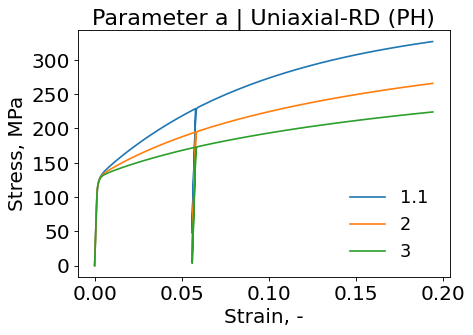

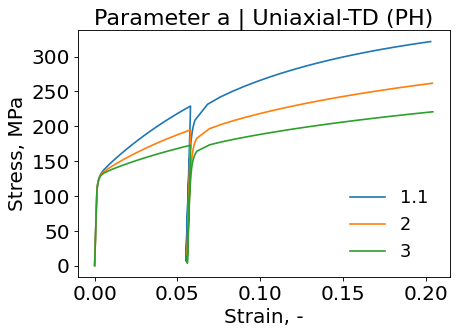

In [6]:
paramValues = ["1.1","2","3"] # <- put the postprocessed files here and rename to the param's value change. Remmeber to keep the exponent
paramName = "a" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "a" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)


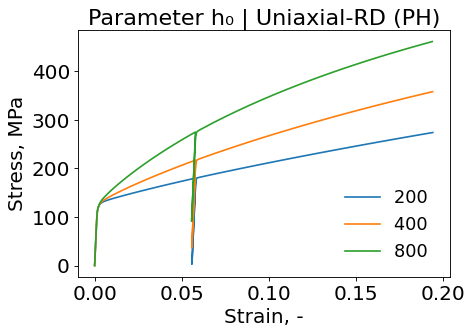

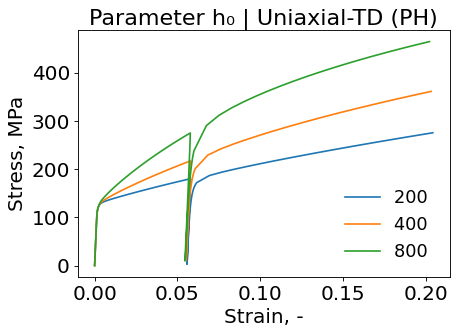

In [6]:
paramValues = ["200","400","800"]
paramName = "h0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "h₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

In [14]:
paramValues = ["200","300","400"]
paramName = "tausat" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "τₛₐₜ" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "MPa" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/tausat/200.txt'

<Figure size 480x320 with 0 Axes>

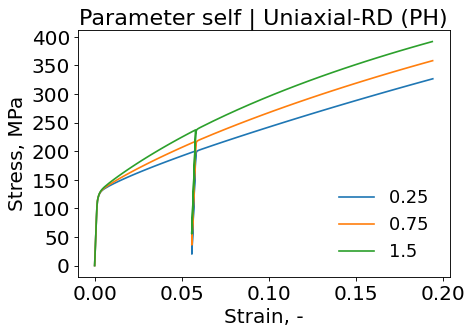

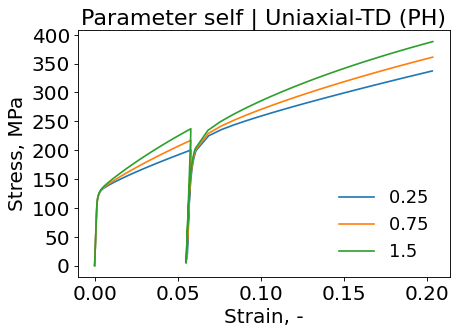

In [7]:
paramValues = ["0.25","0.75","1.5"]
paramName = "self" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "self" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

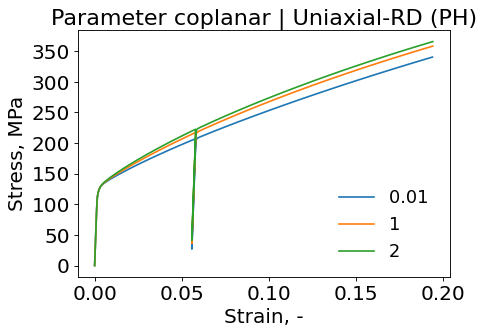

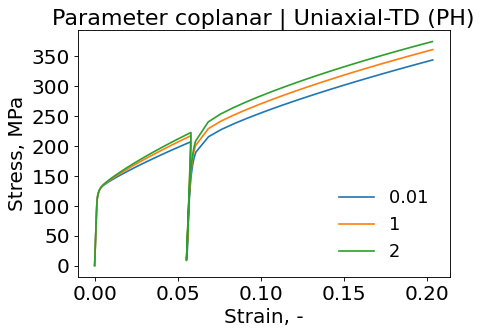

In [12]:
paramValues = ["0.01","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

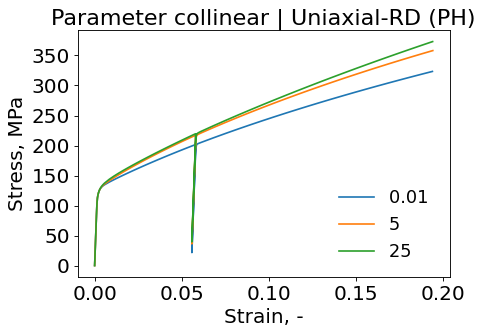

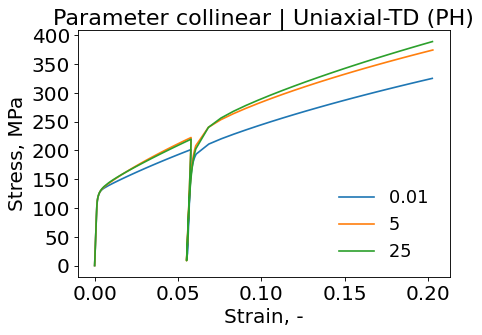

In [33]:
paramValues = ["0.01","5","25"]
paramName = "collinear" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "collinear" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

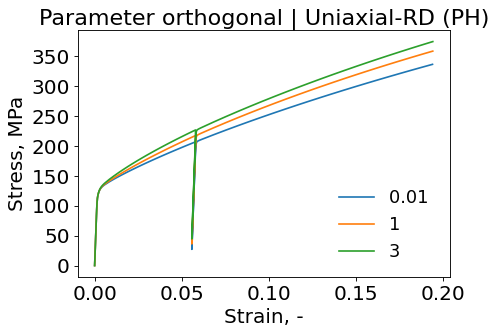

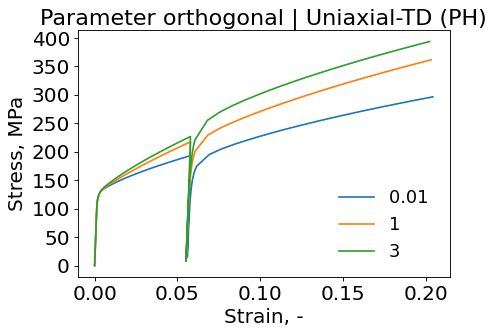

In [34]:
paramValues= ["0.01","1","3"]
paramName = "orthogonal" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "orthogonal" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

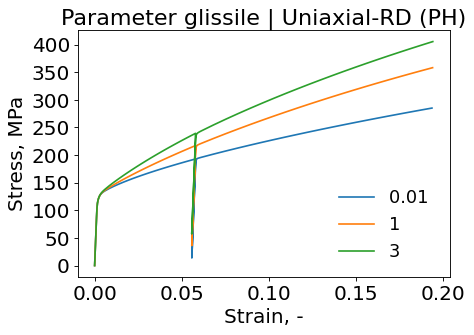

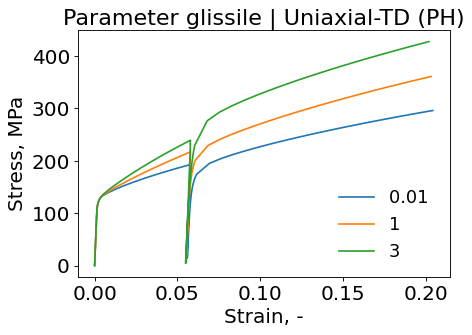

In [37]:
paramValues = ["0.01","1","3"]
paramName = "glissile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "glissile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

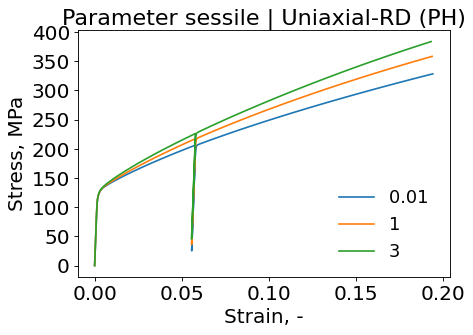

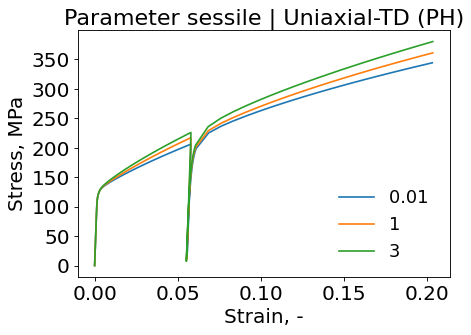

In [38]:
paramValues = ["0.01","1","3"]
paramName = "sessile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "sessile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

## Parameter analysis in the DB model

### Note: need to multiply stress by 1e-6

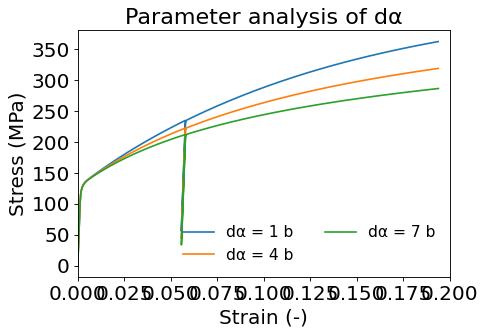

In [9]:
paramValues = ["1","4","7"] # <- put the postprocessed files here and rename to the param's value change
paramName = "dipole"
paramNameLatex = "dα"
paramUnit = "b"
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
#plt.ylim([80, 710])
#plt.xlim([0, 0.2])
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKNonlinear(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
#plt.ylim([80, 710])
#plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



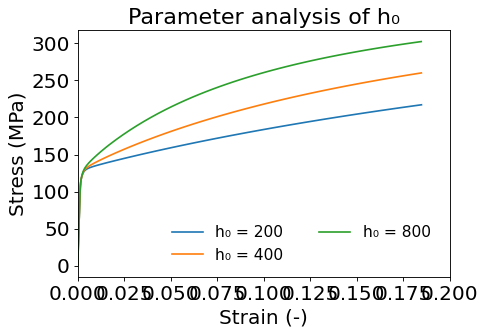

In [4]:
paramValues = ["200","400","800"]
paramName = "h0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "h₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

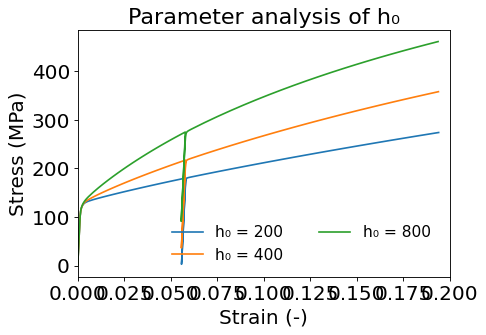

In [6]:
paramValues = ["200","400","800"]
paramName = "h0" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "h₀" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
# plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

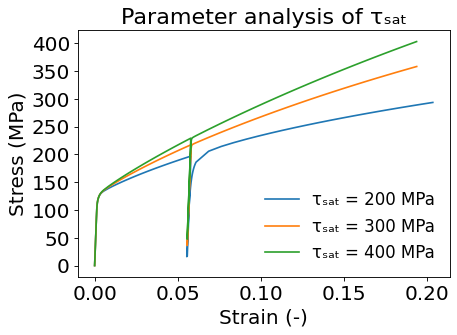

In [18]:
paramValues = ["200","300","400"]
paramName = "tausat" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "τₛₐₜ" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "MPa" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
#plt.ylim([-50, 710])
#plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


In [ ]:
paramValues = ["200","300","400"]
paramName = "tausat" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "τₛₐₜ" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "MPa" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([-50, 710])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 9, ncol=3, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

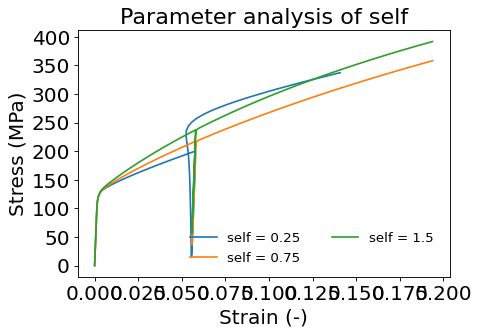

In [10]:
paramValues = ["0.25","0.75","1.5"]
paramName = "self" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "self" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
##plt.ylim([80, 310])
#plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



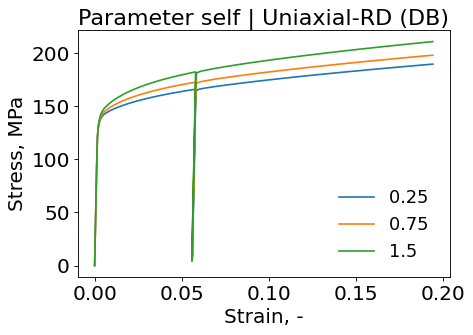

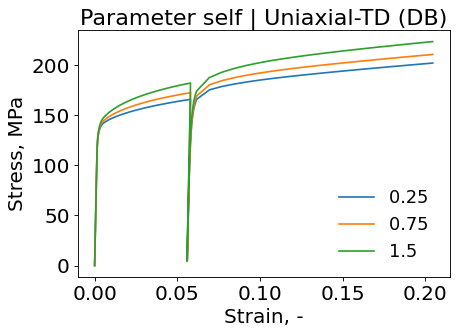

In [5]:
paramValues = ["0.25","0.75","1.5"]
paramName = "self" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "self" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)



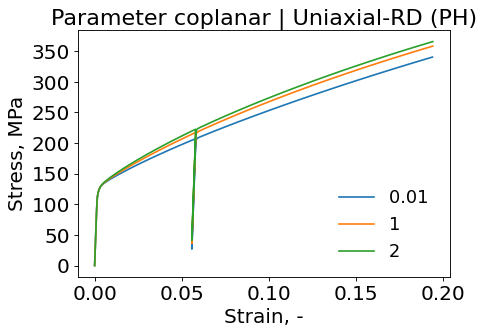

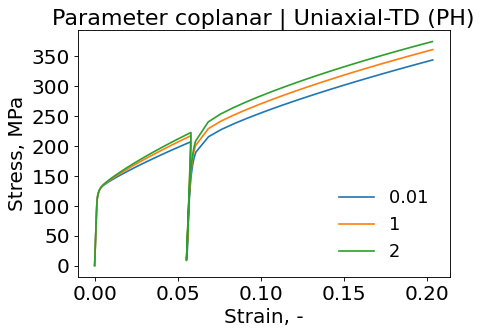

In [7]:
paramValues = ["0.01","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (PH)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)



ValueError: Unrecognized character t in format string

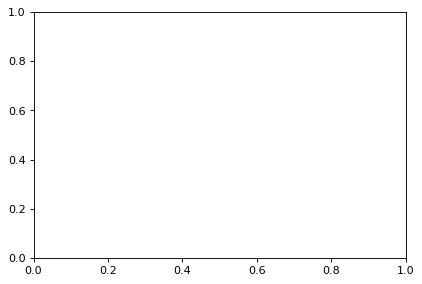

In [27]:
paramValues = ["0.01","0.5","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 5, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)



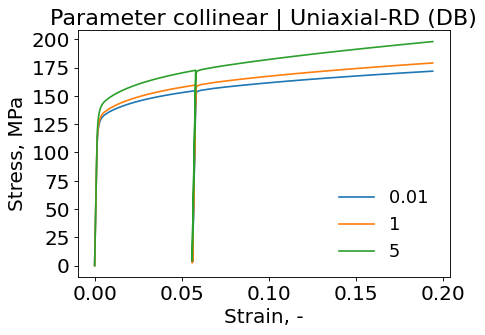

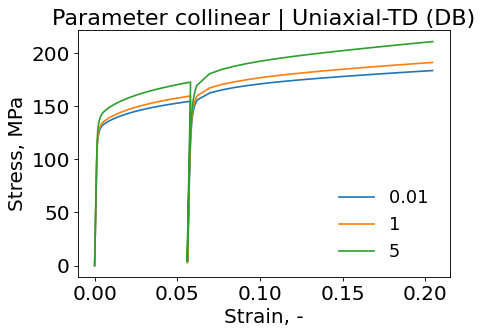

In [33]:
paramValues = ["0.01","1","5"]
paramName = "collinear" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "collinear" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

ValueError: Unrecognized character t in format string

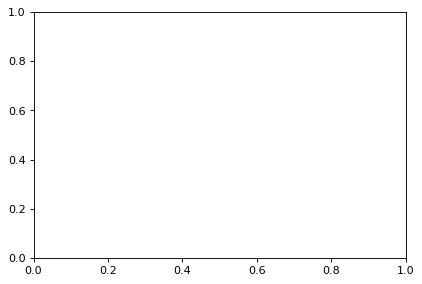

In [13]:
paramValues = ["0.01","1","5"]
paramName = "collinear" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "collinear" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 330])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [ ]:
paramValues= ["0.01","1","3"]
paramName = "orthogonal" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "orthogonal" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_unixial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)


In [ ]:
paramValues= ["0.01","1","3"]
paramName = "orthogonal" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "orthogonal" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_unixial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 6, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [ ]:
paramValues = ["0.01","1","3"]
paramName = "glissile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "glissile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [ ]:
paramValues = ["0.01","1","3"]
paramName = "glissile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "glissile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [ ]:
paramValues = ["0.01","1","3"]
paramName = "sessile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "sessile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [ ]:
paramValues = ["0.01","1","3"]
paramName = "sessile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "sessile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

############################### 
# a
###############################
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/PH/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    #trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramNameLatex} = {paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter analysis of {paramNameLatex}", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.ylim([80, 310])
plt.xlim([0, 0.2])

plt.ylabel('Stress (MPa)', size=size)
plt.xlabel("Strain (-)", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 4, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
# plt.grid()
legend.get_frame().set_linewidth(0.0)

In [6]:
paramValues = ["0.25","0.75","1.5"]
paramName = "self" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "self" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKTrue(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])

plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 3, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"/home/kien/Crystal-Plasticity-COE/notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    trueStrain, trueStress = preprocessDAMASKNonlinear(path)
    trueStress *= 1e-6

    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])



plt.ylabel('True Stress, MPa', size=size)
plt.xlabel("True Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 3, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)


TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 480x320 with 0 Axes>

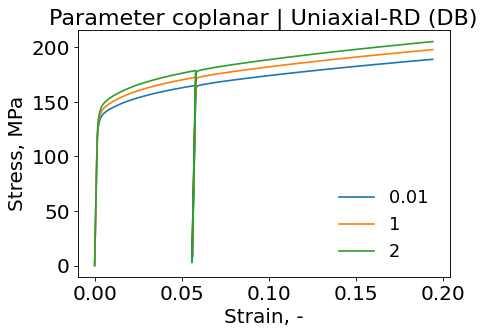

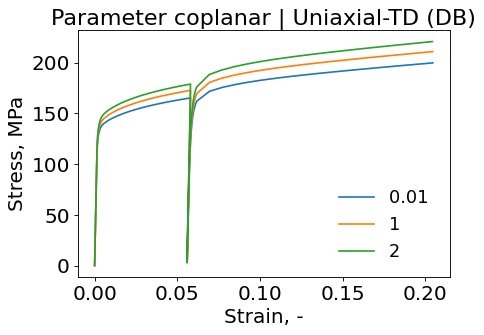

In [5]:
paramValues = ["0.01","1","2"]
paramName = "coplanar" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "coplanar" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

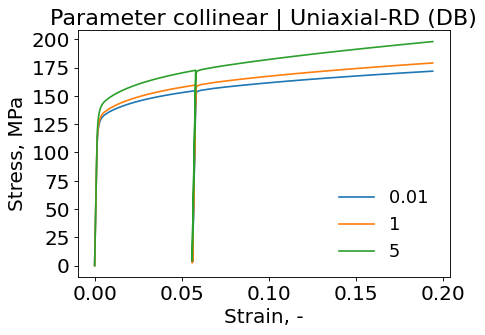

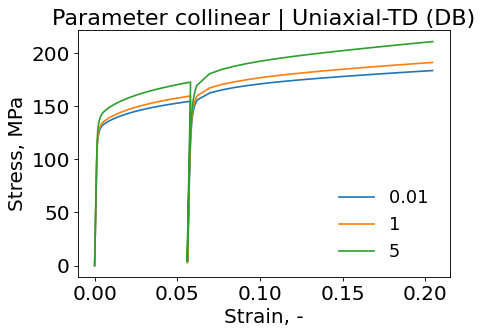

In [9]:
paramValues = ["0.01","1","5"]
paramName = "collinear" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "collinear" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18

figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

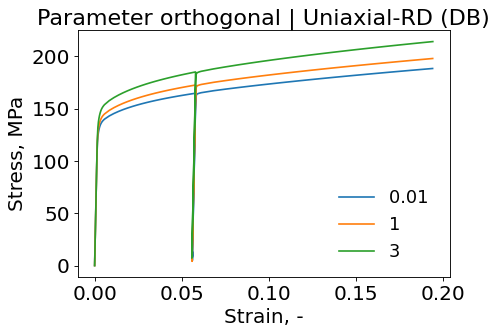

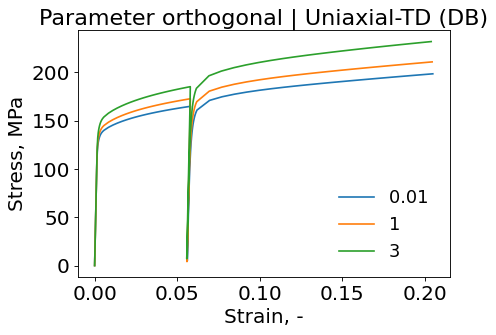

In [10]:
paramValues= ["0.01","1","3"]
paramName = "orthogonal" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "orthogonal" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

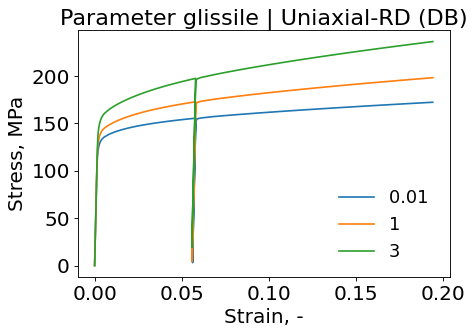

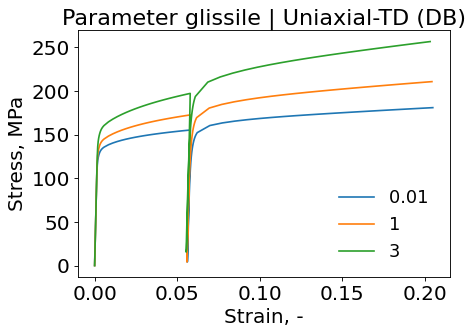

In [11]:
paramValues = ["0.01","1","3"]
paramName = "glissile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "glissile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

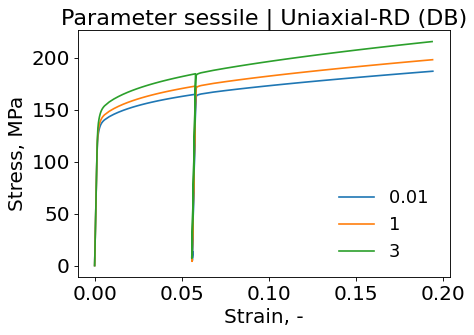

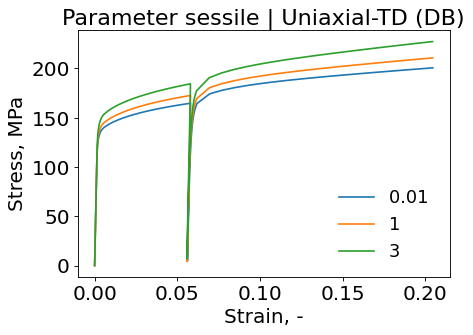

In [12]:
paramValues = ["0.01","1","3"]
paramName = "sessile" # <- Change this to the correct parameter. Look up paramNames in GUI.py 
paramNameLatex = "sessile" # <- Change this to the correct formatted name. Look up paramsFormatted in GUI.py
paramUnit = "" # <- Change this to the correct unit. Look up paramsUnit in GUI.py
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    #trueStress *= 1e-6
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

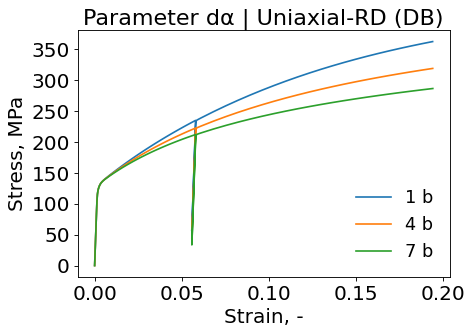

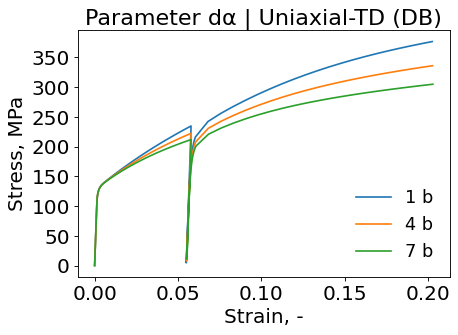

In [25]:
paramValues = ["1","4","7"] # <- put the postprocessed files here and rename to the param's value change
paramName = "dipole"
paramNameLatex = "dα"
paramUnit = "b"
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)


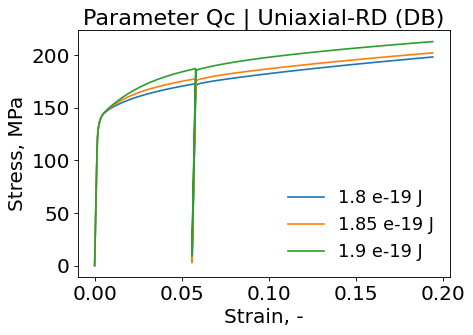

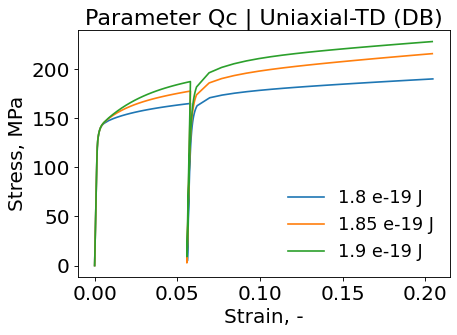

In [28]:
paramValues = ["1.8","1.85", "1.9"]
paramName = "Qc"
paramNameLatex = "Qc"
paramUnit = "e-19 J"
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

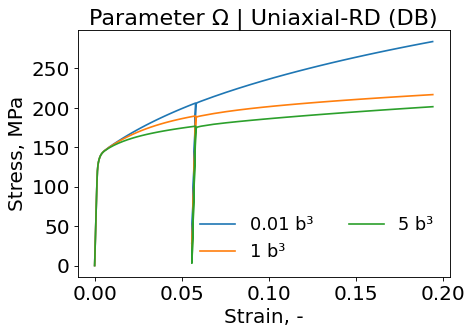

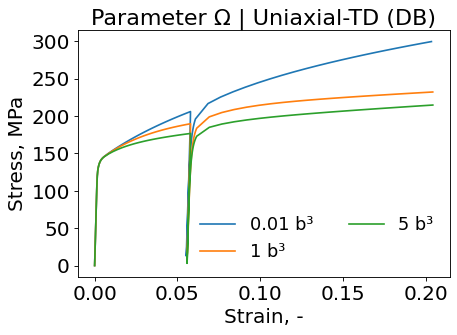

In [17]:
paramValues = ["0.01","1","5"] # <- put the postprocessed files here and rename to the param's value change
paramName = "omega"
paramNameLatex = "Ω"
paramUnit = "b³"
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=2, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

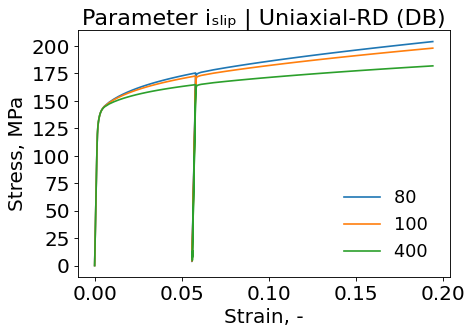

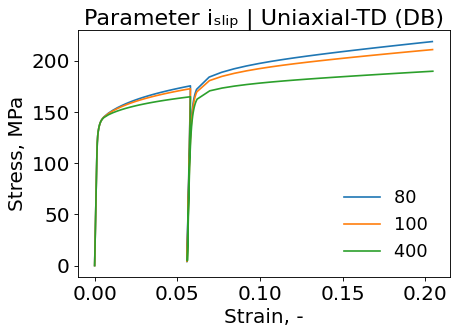

In [33]:
paramValues = ["80","100","400"]
paramName = "islip"
paramNameLatex = "iₛₗᵢₚ"
paramUnit = ""
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

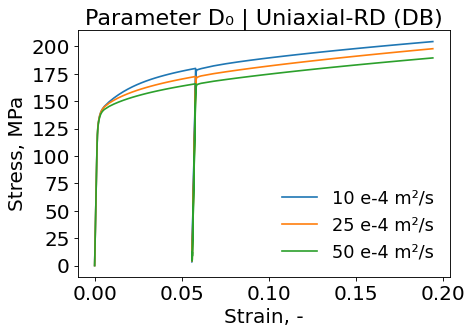

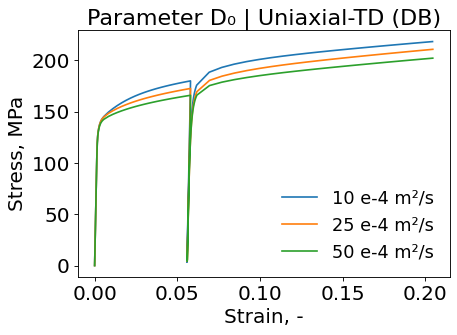

In [13]:
paramValues = ["10","25","50"]
paramName = "D0"
paramNameLatex = "D₀"
paramUnit = "e-4 m²/s"
size = 18
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_RD/DB/{paramName}/{paramValue}.txt"
    strainstress  = preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)

plt.title(f"Parameter {paramNameLatex} | Uniaxial-RD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon= False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)

#---------------------------------------------------------
figure(figsize=(6, 4), dpi=80)
for paramValue in paramValues: 
    path = f"notebooks/analysis_parameters_nonlinear_uniaxial_TD/DB/{paramName}/{paramValue}.txt"
    strainstress =  preprocessDAMASKNonlinear(path)
    trueStrain = strainstress["strain"]
    trueStress = strainstress["stress"]
    trueStress *= 1e-6
    plt.plot(trueStrain, trueStress, label = f"{paramValue} {paramUnit}")#, marker='.', markersize=5)
plt.title(f"Parameter {paramNameLatex} | Uniaxial-TD (DB)", size=size + 2)
plt.xticks(fontsize=size)    
plt.yticks(fontsize=size)  
plt.xticks([0,0.05,0.1,0.15,0.2])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
legend = plt.legend(loc=4, frameon=False, fontsize=size - 2, ncol=1, facecolor='white') #, shadow =True, framealpha=1)
legend.get_frame().set_linewidth(0.0)